In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.callbacks import EarlyStopping

# Load and preprocess the data
data = pd.read_csv('nvda_data.csv')
data["Close"]=pd.to_numeric(data.Close,errors='coerce')

# Drop rows with missing values
data = data.dropna()

In [4]:
# We have data from 2018 to 2023 (1258 days approx.)
# Let's use data from 2018 to 2022 for training (about 1006 days, 80% of the data)
train_data = data.iloc[:1006]

# Then use data from 2022 to 2023 for testing (about 252 days, 20% of the data)
test_data = data.iloc[1006:]

# Select the features we are interested in
train_values = train_data[["Open", "High", "Low", "Close", "Volume"]].values

sc = MinMaxScaler(feature_range=(0,1))
train_values_scaled = sc.fit_transform(train_values)

In [5]:
# Prepare the training set
X_train = []
y_train = []

for i in range(60, train_values_scaled.shape[0]):
    X_train.append(train_values_scaled[i-60:i, :])  # all features
    y_train.append(train_values_scaled[i, 3])  # 'Close' price is our target

In [6]:
# Fit a separate scaler for the 'Close' price
sc_close = MinMaxScaler(feature_range=(0,1))
close_price = train_data['Close'].values.reshape(-1,1)
sc_close.fit_transform(close_price)

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # add the batch_size axis

In [7]:
# Build the model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss="mean_squared_error")

# Apply Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

Epoch 1/100
24/24 - 4s - loss: 0.0070 - val_loss: 0.0080 - 4s/epoch - 179ms/step
Epoch 2/100
24/24 - 2s - loss: 0.0011 - val_loss: 0.0099 - 2s/epoch - 70ms/step
Epoch 3/100
24/24 - 2s - loss: 0.0011 - val_loss: 0.0075 - 2s/epoch - 72ms/step
Epoch 4/100
24/24 - 2s - loss: 8.7188e-04 - val_loss: 0.0073 - 2s/epoch - 74ms/step
Epoch 5/100
24/24 - 2s - loss: 0.0011 - val_loss: 0.0079 - 2s/epoch - 77ms/step
Epoch 6/100
24/24 - 2s - loss: 9.1147e-04 - val_loss: 0.0073 - 2s/epoch - 76ms/step
Epoch 7/100
24/24 - 2s - loss: 0.0010 - val_loss: 0.0066 - 2s/epoch - 77ms/step
Epoch 8/100
24/24 - 2s - loss: 9.0845e-04 - val_loss: 0.0070 - 2s/epoch - 83ms/step
Epoch 9/100
24/24 - 2s - loss: 8.1457e-04 - val_loss: 0.0061 - 2s/epoch - 80ms/step
Epoch 10/100
24/24 - 2s - loss: 9.7263e-04 - val_loss: 0.0062 - 2s/epoch - 91ms/step
Epoch 11/100
24/24 - 2s - loss: 7.6921e-04 - val_loss: 0.0060 - 2s/epoch - 83ms/step
Epoch 12/100
24/24 - 2s - loss: 7.7700e-04 - val_loss: 0.0064 - 2s/epoch - 80ms/step
Epoch 13

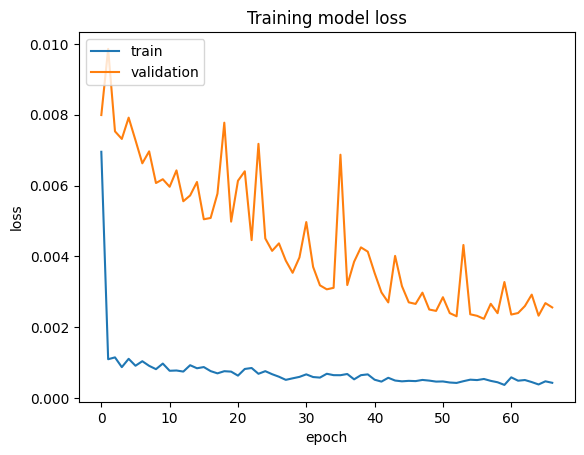

In [8]:
# Fit the model
hist = model.fit(X_train, y_train, validation_split=0.2, epochs = 100, batch_size = 32, verbose=2, callbacks=[es])

# Plotting the training loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Test the model
# Convert columns to numeric
for col in ["Open", "High", "Low", "Close", "Volume"]:
    test_data.loc[:, col] = pd.to_numeric(test_data[col], errors='coerce')
test_data = test_data.dropna()

In [10]:
# Apply the same transformations on test data
test_data_scaled = sc.transform(test_data[["Open", "High", "Low", "Close", "Volume"]].values)
X_test = []
for i in range(60, test_data_scaled.shape[0]):
    X_test.append(test_data_scaled[i-60:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) 

6/6 [==============================] - 1s 23ms/step


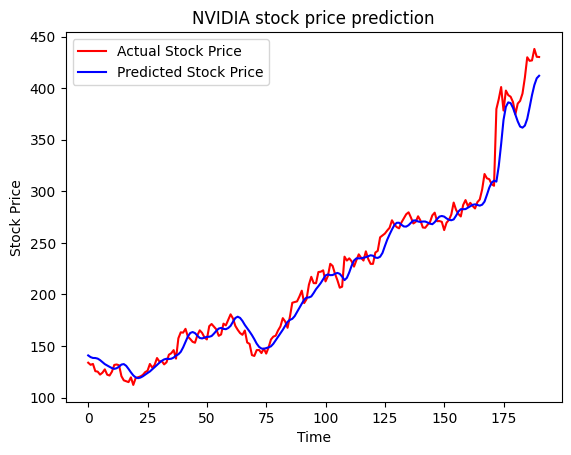

In [11]:
# Make the prediction
pred_price_scaled = model.predict(X_test)

# Undo the scaling
pred_price = sc_close.inverse_transform(pred_price_scaled)

# Plot the results
plt.plot(test_data['Close'].values[60:], color = 'red', label = 'Actual Stock Price')
plt.plot(pred_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('NVIDIA stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()